https://www.kaggle.com/landlord/handwriting-recognition

All the imports 

In [ ]:
# all the imports for the google drive 
from google.colab import drive

# imports for running the project
import os 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt # plotting
import cv2 # Open CV Python image processing
from google.colab.patches import cv2_imshow

# This imports are fro CNN and RNN network

from keras import backend as K
from keras.optimizers import Adam
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Input, Dense, Activation, Dropout,Bidirectional
from keras.layers import Reshape, Lambda, BatchNormalization
from keras.layers.merge import add, concatenate
from keras.models import Model
from keras.layers.recurrent import LSTM
from keras.layers import Bidirectional
from tensorflow import keras

K.set_learning_phase(0)


Instructions for updating:
Simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


Mounting the drive and uploading the data


In [ ]:
# we connect gdrive to google colab
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# we unzip over data
!unzip gdrive/My\ Drive/archive.zip > /dev/null # Dont show any output

Exploring the data 

In [ ]:
# Reading the csv's into the data frames
train = pd.read_csv('written_name_train_v2.csv')
valid = pd.read_csv('written_name_validation_v2.csv')

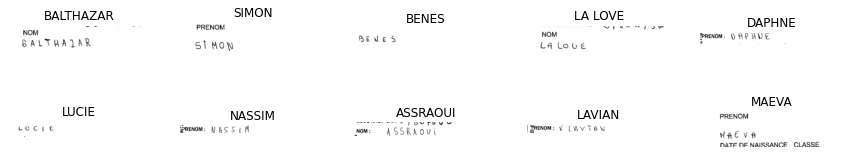

In [ ]:
# showing some images of our data set
plt.figure(figsize=(15, 10))

for i in range(10):
    ax = plt.subplot(2, 5, i+1)
    img_dir = 'train_v2/train/'+train.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE) # RGB and Grey 
    plt.imshow(image, cmap = 'gray')
    plt.title(train.loc[i, 'IDENTITY'], fontsize=12)
    plt.axis('off')

plt.subplots_adjust(wspace=0.2, hspace=-0.8)

Cleaning the data

In [ ]:
# In the train csv there are NANs Remove them from training set.
# Also there are some names which are written UNREADABLE
# remove them from the training set 
train.dropna(axis = 0,inplace = True)
valid.dropna(axis = 0,inplace = True)

In [ ]:
# We are removing the unreadable files from our training and validation set
train[train['IDENTITY'] == 'UNREADABLE']
train = train[train['IDENTITY'] != 'UNREADABLE'] 
valid = valid[valid['IDENTITY'] != 'UNREADABLE'] 

In [ ]:
# We are setting all the names to capitals
train['IDENTITY'] = train['IDENTITY'].str.upper()
valid['IDENTITY'] = valid['IDENTITY'].str.upper()

In [ ]:
# We are resetting the index
train.reset_index(inplace= True)
valid.reset_index(inplace= True)
train

,index,FILENAME,IDENTITY
0,0,TRAIN_00001.jpg,BALTHAZAR
1,1,TRAIN_00002.jpg,SIMON
2,2,TRAIN_00003.jpg,BENES
3,3,TRAIN_00004.jpg,LA LOVE
4,4,TRAIN_00005.jpg,DAPHNE
...,...,...,...
330289,330956,TRAIN_330957.jpg,LENNY
330290,330957,TRAIN_330958.jpg,TIFFANY
330291,330958,TRAIN_330959.jpg,COUTINHO DESA
330292,330959,TRAIN_330960.jpg,MOURAD


Preprocess the data

In [ ]:
# We create a preprocess function 
# This function changes every image size into the image size(64,256)
# this function returns the image 
def preprocess(img):
  final_img = np.ones([64,256])*255
  (h,w) = img.shape
  if h > 64:
    img = img[:64,:]
  if w > 256:
    img = img[:,:256]
  final_img[:h,:w] = img
  return cv2.rotate(final_img,cv2.ROTATE_90_CLOCKWISE)



In [ ]:
# we give the actual size of train and valid set 
train_size = 20000 # this is the acceptable size as more size than this causes the system to crash
valid_size = 2000

In [ ]:
# We create train_input = [] and valid_input = []
# We create a loop for train_input and valid_input
# Now we read every image and preprocess the image
# Then we normalize the image into 0 & 1
# And append image into train_input and valid_input
# We reshape the train_input and valid_input list and make train_x and valid_x array 
# Syntex error 
train_input = []
valid_input = []
for i in range(train_size):
  img_dir = 'train_v2/train/'+train.loc[i, 'FILENAME']
  img = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
  img = preprocess(img)
  img = img / 255
  train_input.append(img)

for i in range(valid_size):
  img_dir = 'validation_v2/validation/'+valid.loc[i, 'FILENAME']
  img_1 = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
  img = preprocess(img_1)
  img = img / 255
  valid_input.append(img)

train_x = np.array(train_input).reshape(-1, 256, 64, 1)
valid_x = np.array(valid_input).reshape(-1, 256, 64, 1)

In [ ]:
print(valid_x.shape)
print(train_x.shape)

(2000, 256, 64, 1)
(20000, 256, 64, 1)


Preparing the preprocessed data for the Our Neural Network

https://towardsdatascience.com/intuitively-understanding-connectionist-temporal-classification-3797e43a86c


In [ ]:
# CTC Loss Connectionist Temporal Classification
# we are creatng two function
# label_to_num() its convert the label input into indexs.
# num_to_label() its convert the index value of label into character.
# we store output in list.
alphabets = "ABCDEFGHIJKLMNOPQRSTUVWXYZ- '"
max_len_input = 24
num_of_characters = len(alphabets) + 1 # the plus one is for the special symbol used in the CTC loss
no_of_timestamps = 64

def label_to_num(label):
  list_1 = []
  for i in label:
    list_1.append(alphabets.index(i))
  return list_1

def num_to_label(label):
  list_2 = []
  for i in label:
    if i == -1:
      break
    list_2.append(alphabets[i])
  return list_2

In [ ]:
train_y = np.ones([train_size, max_len_input]) * -1
train_label_len = np.zeros([train_size, 1])
train_input_len = np.ones([train_size, 1]) * (no_of_timestamps-2)
train_output = np.zeros([train_size])

for i in range(train_size):
    train_label_len[i] = len(train.loc[i, 'IDENTITY'])
    train_y[i, 0:len(train.loc[i, 'IDENTITY'])]= label_to_num(train.loc[i, 'IDENTITY'])    



In [ ]:
valid_y = np.ones([valid_size,max_len_input]) * -1
valid_label_len = np.zeros([valid_size, 1]) 
valid_input_len = np.ones([valid_size, 1]) * (no_of_timestamps-2) 
valis_output = np.zeros([valid_size]) 

# we store the index value of every label in train_y.
# train_label_len() we store the length of label.

for i in range(valid_size):
  valid_label_len[i] = len(valid.loc[i,'IDENTITY'])
  valid_y[i,0:len(valid.loc[i,'IDENTITY'])] = label_to_num(valid.loc[i,'IDENTITY'])

valid_y

array([[ 1.,  8., 11., ..., -1., -1., -1.],
       [11.,  0., 20., ..., -1., -1., -1.],
       [11.,  4.,  0., ..., -1., -1., -1.],
       ...,
       [ 7., 14., 12., ..., -1., -1., -1.],
       [19.,  4., 12., ..., -1., -1., -1.],
       [ 9.,  0.,  1., ..., -1., -1., -1.]])

CREATING OUR NEURAL NETWORK

In [ ]:
# # Loss and train functions, network architecture
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    # the 2 is critical here since the first couple outputs of the RNN
    # tend to be garbage:
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

In [ ]:
# MODEL INPUT SHAPE
input_shape = (256, 64, 1)     # (256, 64, 1)

# Make Networkw
# This create its own tensers
inputs = Input(name='the_input', shape=input_shape, dtype='float32')  # (None, 256, 64, 1)

# Convolution layer start (VGG)
# Each cnn layer find complex features
# First layer search for normal features
# Second layer search complex features compare to first cnn layer
# This go on until last cnn layer

# Each cnn layer compress the size of image so at last layer image size is so small
# That's why we use PADDING so that input and output shape of image are same.

# When you procress large amount of data than sometime your system is crashing
# So we use BATCHNORMALIZATION. It devide your data in batches

# We use activation function 'relu'
# f(x) = max(0, x)
# This function returns 0 if it receives any negative input, but for any positive value  x  it returns that value back

# MaxPooling selects maximun element from feture map covered by filters
# MaxPooling has no weights and its no.of channels are same

# The first layer with 64 filters of window size 3x3
inner = Conv2D(64, (3, 3), padding='same', name='conv1', kernel_initializer='he_normal')(inputs)  # (None, 256, 64, 64)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max1')(inner)  # (None,128, 32, 64)

# The second layer with 128 filters of window size 3x3
inner = Conv2D(128, (3, 3), padding='same', name='conv2', kernel_initializer='he_normal')(inner)  # (None, 128, 32, 128)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max2')(inner)  # (None, 64, 16, 128)

# The third layer with 256 filters of window size 3x3
inner = Conv2D(256, (3, 3), padding='same', name='conv3', kernel_initializer='he_normal')(inner)  # (None, 64, 16, 256)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)

# The forth layer with 256 filters of window size 3x3
inner = Conv2D(256, (3, 3), padding='same', name='conv4', kernel_initializer='he_normal')(inner)  # (None, 64, 16, 256)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(1, 2), name='max3')(inner)  # (None, 64, 8, 256)

# The fifth layer with 512 filters of window size 3x3
inner = Conv2D(512, (3, 3), padding='same', name='conv5')(inner)  # (None, 64, 8, 512)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(1, 2), name='max4')(inner)  # (None, 64, 4, 512)

# The sixth layer with 512 filters of window size 2x2
inner = Conv2D(1024, (2, 2), padding='same', kernel_initializer='he_normal', name='con6')(inner)  # (None, 64, 4, 512)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)

# CNN to RNN
# RNN is use for understading the data so its input size must be in 2D
inner = Reshape(target_shape=((64, 4096)), name='reshape')(inner)  
inner = Dense(64, activation='relu', kernel_initializer='he_normal', name='dense1')(inner)

# RNN network is start from here
# RNN layer (lstm = 'Long Sort Term Memory')
# lstm remeber the data that important to whole sentence
# we use lstm and lstm bidirectional RNN 

lstm_1 = Bidirectional(LSTM(300, return_sequences = True, dropout=0.4))(inner)
lstm_2 = Bidirectional(LSTM(300, return_sequences = True, dropout=0.4))(lstm_1)

lstm_merged = concatenate([lstm_1,lstm_2])
lstm_merged = BatchNormalization()(lstm_merged)

lstm_3 = Bidirectional(LSTM(300, return_sequences = True, dropout=0.4))(lstm_merged)
lstm_4 = Bidirectional(LSTM(300, return_sequences = True, dropout=0.4))(lstm_merged)

lstm_merged_1 = concatenate([lstm_3,lstm_4])
lstm_merged_1 = BatchNormalization()(lstm_merged_1)

lstm_5 = Bidirectional(LSTM(300, return_sequences = True, dropout=0.4))(lstm_merged_1)
lstm_6 = Bidirectional(LSTM(300, return_sequences = True, dropout=0.4))(lstm_merged_1)

lstm_merged_2 = concatenate([lstm_5,lstm_6])
lstm_merged_2 = BatchNormalization()(lstm_merged_2)

# transforms RNN output to character activations:
inner = Dense(num_of_characters, kernel_initializer='he_normal',name='dense2')(lstm_merged_2)
y_pred = Activation('softmax', name='softmax')(inner)

labels = Input(name='the_labels', shape=[max_len_input], dtype='float32') # (None ,8)
input_length = Input(name='input_length', shape=[1], dtype='int64')     # (None, 1)
label_length = Input(name='label_length', shape=[1], dtype='int64')     # (None, 1)

# Keras doesn't currently support loss funcs with extra parameters
# so CTC loss is implemented in a lambda layer
loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length]) #(None, 1)

model = Model(inputs=inputs, outputs=y_pred)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
the_input (InputLayer)          [(None, 256, 64, 1)] 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 256, 64, 64)  640         the_input[0][0]                  
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 64, 64)  256         conv1[0][0]                      
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 64, 64)  0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [ ]:
# real model wrapper and dummy model , loss function, we predict that model
model_final = Model(inputs=[inputs, labels, input_length, label_length], outputs=loss_out)
model_final.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=Adam(lr = 0.0001))

model_final.fit(x=[train_x, train_y, train_input_len, train_label_len], y=train_output, 
                validation_data=([valid_x, valid_y, valid_input_len, valid_label_len], valis_output),
                epochs=20, batch_size=128)

Epoch 1/20
157/157 [==============================] - 131s 832ms/step - loss: 38.7089 - val_loss: 38.8275
Epoch 2/20
157/157 [==============================] - 128s 816ms/step - loss: 22.0233 - val_loss: 21.1983
Epoch 3/20
157/157 [==============================] - 128s 814ms/step - loss: 18.8543 - val_loss: 19.0228
Epoch 4/20
157/157 [==============================] - 128s 814ms/step - loss: 16.0287 - val_loss: 14.2763
Epoch 5/20
157/157 [==============================] - 128s 815ms/step - loss: 12.5044 - val_loss: 11.3195
Epoch 6/20
157/157 [==============================] - 128s 813ms/step - loss: 9.4396 - val_loss: 9.5757
Epoch 7/20
157/157 [==============================] - 128s 813ms/step - loss: 6.9629 - val_loss: 6.4577
Epoch 8/20
157/157 [==============================] - 128s 813ms/step - loss: 5.4247 - val_loss: 7.5062
Epoch 9/20
157/157 [==============================] - 128s 812ms/step - loss: 4.4247 - val_loss: 5.1285
Epoch 10/20
157/157 [==============================] -

In [ ]:
# loading the model 
model = keras.models.load_model('/gdrive/My_model')


OSError: ignored

In [ ]:
preds = model.predict(valid_x)
decoded = K.get_value(K.ctc_decode(preds, input_length=np.ones(preds.shape[0])*preds.shape[1], 
                                   greedy=True)[0][0])

prediction = []
for i in range(valid_size):
    prediction.append(num_to_label(decoded[i]))

Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.


In [ ]:
y_true = valid.loc[0:valid_size, 'IDENTITY']
correct_char = 0
total_char = 0
correct = 0

for i in range(valid_size):
    pr = prediction[i]
    tr = y_true[i]
    total_char += len(tr)
    # print(str(pr),list(tr))
    for j in range(min(len(tr), len(pr))):
        print(tr[j],pr[j])
        if tr[j] == pr[j]:
            correct_char += 1
    # print("----")   
    if pr == list(tr) :
        print(pr)
        correct += 1 
    
print('Correct characters predicted : %.2f%%' %(correct_char*100/total_char))
print('Correct words predicted      : %.2f%%' %(correct*100/valid_size))

Streaming output truncated to the last 5000 lines.
H H
O O
N N
['C', 'O', 'N', 'C', 'H', 'O', 'N']
L L
E E
O O
['L', 'E', 'O']
A A
L L
E E
X X
I I
S S
['A', 'L', 'E', 'X', 'I', 'S']
R R
U U
I U
S Y
C S
H S
A C
E H
R A
T E
C C
A A
M M
B B
O O
['C', 'A', 'M', 'B', 'O']
D D
E E
U U
D D
O O
N N
['D', 'E', 'U', 'D', 'O', 'N']
A A
N N
T T
O O
I I
N N
E E
['A', 'N', 'T', 'O', 'I', 'N', 'E']
E K
L E
I L
N I
A N
G G
O O
M M
E E
S S
['G', 'O', 'M', 'E', 'S']
C C
O O
L L
O D
M M
B B
A A
S S
A A
S S
H H
A A
['S', 'A', 'S', 'H', 'A']
T T
A A
R R
E E
K K
['T', 'A', 'R', 'E', 'K']
L L
E E
N N
O O
R R
M M
A A
N N
D D
  J
J A
A F
F F
F R
R E
D D
I I
L L
A A
['D', 'I', 'L', 'A']
C C
L L
A A
I I
R R
E E
['C', 'L', 'A', 'I', 'R', 'E']
D D
E E
S S
C C
H H
A A
M N
P P
S S
N N
U U
R R
I I
A A
['N', 'U', 'R', 'I', 'A']
S S
O O
F E
I I
A A
N M
E E
P P
E E
T T
E E
R R
['P', 'E', 'T', 'E', 'R']
L L
O O
U U
I I
S S
   
- -
  A
A N
N T
T O
O I
I N
N E
V V
A A
N N
D D
E E
P P
O O
E E
L L
['V', 'A', 'N', 'D', 'E', '

In [ ]:
# Save only when you have changed the characteristics of the model
model.save('/gdrive/My_model')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /gdrive/My_model/assets
